# Preprocessing data

In [877]:
# importando bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [878]:
# carregando base de dados
EFPg = np.load("DataEFPsJetTagging/EFP d5-connected-not_normalized/g_efps_d5_primed.npy")
EFPq = np.load("DataEFPsJetTagging/EFP d5-connected-not_normalized/q_efps_d5_primed.npy")
EFPt = np.load("DataEFPsJetTagging/EFP d5-connected-not_normalized/t_efps_d5_primed.npy")

## Visualization

In [879]:
dataset = EFPg # escolhendo o conjunto de dados
column_index = 40 # escolhendo o índice da coluna

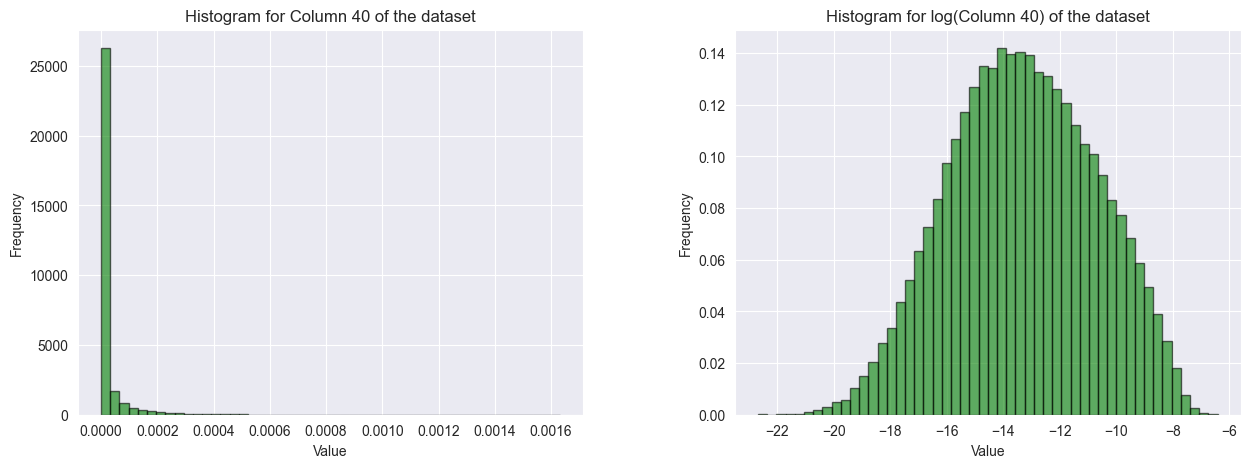

In [880]:
data = dataset[:, column_index] # valores da coluna
data_log = np.log(data) # logarithmic-scaling

nbins = 50 # número de bins no histograma

fig, axes = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1]})
fig.subplots_adjust(wspace=0.3)

# histograma - sem normalizar
axes[0].hist(data, bins=nbins, density=True, alpha=0.6, color='g', edgecolor='black')
axes[0].set_ylabel("Frequency")
axes[0].set_xlabel("Value")
axes[0].set_title(f'Histogram for Column {column_index} of the dataset')

# histograma - normalizando
axes[1].hist(data_log, bins=nbins, density=True, alpha=0.6, color='g', edgecolor='black')
axes[1].set_ylabel("Frequency")
axes[1].set_xlabel("Value")
axes[1].set_title(f'Histogram for log(Column {column_index}) of the dataset')

plt.show()

## Normalizations

In [881]:
def norm(n,data):
    # n = 0, 1, 2, 3, 4, 5
    
    if n==0:
        return data
    elif n==1:
        return MinMaxScaler().fit_transform(data)
    elif n==2:
        return StandardScaler().fit_transform(data)
    elif n==3:
        return np.log(data)
    elif n==4:
        return MinMaxScaler().fit_transform(np.log(data))
    else: # n==5
        return StandardScaler().fit_transform(np.log(data))
    
# lembrando que não é possível aplicar MinMax/Standard e depois log, por isso não acrescentamos essas opções.

In [882]:
# escolhendo a normalização
n = 3

## Partitioning and Splitting

In [883]:
def split(tagging):
    # tagging = "top" ou não (para quark/gluon tagging)
    
    # separação de variáveis preditoras (features) e alvo (target)
    X_g,y_g = EFPg, np.zeros((EFPg.shape[0], 1))
    X_q,y_q = EFPq, np.zeros((EFPq.shape[0], 1)) if tagging == "top" else np.ones((EFPq.shape[0], 1))
    X_t,y_t = EFPt, np.ones((EFPt.shape[0], 1)) # não vai usar no caso tagging == qg
    
    # particionamento (amostragem estratificada)
    X_g_train, X_g_test, y_g_train, y_g_test = train_test_split(X_g, y_g, test_size=0.2, random_state=1)
    X_q_train, X_q_test, y_q_train, y_q_test = train_test_split(X_q, y_q, test_size=0.2, random_state=1)
    X_t_train, X_t_test, y_t_train, y_t_test = train_test_split(X_t, y_t, test_size=0.2, random_state=1) if tagging == "top" else [np.empty((0, arr.shape[1])) for arr in [X_q_train, X_q_test, y_q_train, y_q_test]]

    # concatenando g, q, t
    X_train, X_test, y_train, y_test = (
        np.concatenate((X_g_train, X_q_train, X_t_train), axis=0),
        np.concatenate((X_g_test, X_q_test, X_t_test), axis=0),
        np.concatenate((y_g_train, y_q_train, y_t_train), axis=0),
        np.concatenate((y_g_test, y_q_test, y_t_test), axis=0))
    
    # normalização
    X = np.concatenate((X_train, X_test), axis=0)
    X = norm(n, X)
    X_train, X_test = X[:len(X_train)], X[len(X_train):]
    
    return X_train, X_test, y_train, y_test

In [884]:
# escolhendo se vamos fazer top tagging ou quark/gluon tagging
tagging = "qg"

In [885]:
X_train, X_test, y_train, y_test = split(tagging)

# Model

In [886]:
# escolhendo o modelo
model = LinearDiscriminantAnalysis() # LinearDiscriminantAnalysis() ou QuadraticDiscriminantAnalysis(tol=1.0e-6)
model.fit(X_train, y_train.ravel())

LinearDiscriminantAnalysis()

Intercept: -29.954801800449907


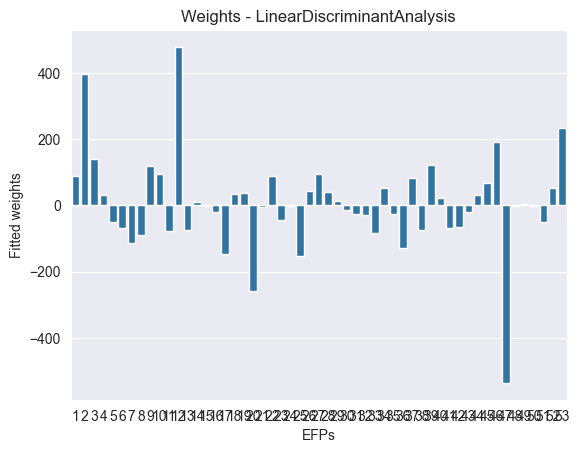

In [887]:
# se o model for linear, podemos obter o intercepto e os pesos
# não executar essa célula se o modelo não possuir intercept_ ou coef_

# intercept
print('Intercept:', model.intercept_[0])

# weights
coef = model.coef_[0]
sns.barplot (x=np.arange(1, len(coef)+1), y=coef)
plt.xlabel("EFPs")
plt.ylabel("Fitted weights")
plt.title("Weights - LinearDiscriminantAnalysis");

# Performance metrics

In [888]:
def choose_set(set):
    # set == "train", "test"
    
    if set == "train":
        return X_train, y_train
    else: # set == "test"
        return X_test, y_test

In [889]:
# escolhendo se vamos avaliar o desempenho do conjunto de treinamento ou de teste
set = "test"

In [890]:
X_set, y_set = choose_set(set)

Classification Report:
               precision    recall  f1-score   support

         0.0      0.779     0.791     0.785     35451
         1.0      0.779     0.767     0.773     34136

    accuracy                          0.779     69587
   macro avg      0.779     0.779     0.779     69587
weighted avg      0.779     0.779     0.779     69587

Confusion Matrix:
 [[0.4  0.11]
 [0.11 0.38]]


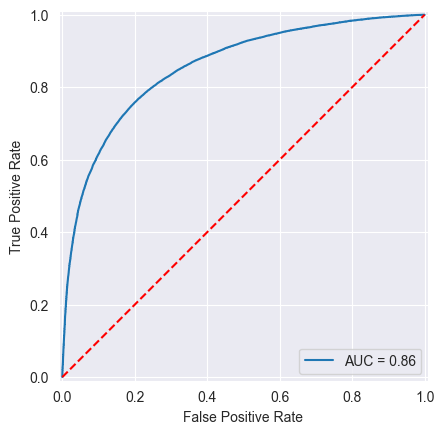

In [891]:
y_pred = model.predict(X_set)
# Classification Report
print('Classification Report:\n',metrics.classification_report(y_set.ravel(), y_pred, digits=3))

# Confusion Matrix
print('Confusion Matrix:\n',metrics.confusion_matrix(y_set.ravel(), y_pred, normalize='all').round(2))

y_predproba = model.predict_proba(X_set)[:, -1]
# ROC curve
fpr, tpr, _ = metrics.roc_curve(y_set.ravel(), y_predproba)
roc_auc = metrics.roc_auc_score(y_set.ravel(), y_predproba)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.plot([0,1],[0,1],'r--')
plt.show()